# GMM method analysis and final errors for DS-II

In [ ]:
# Set to true if on COLAB
USING_COLAB = False

In [ ]:
# If using google colab
if USING_COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive")
    import os
    # Set to the folder the repo was cloned
    os.chdir("/content/gdrive/MyDrive/Colab Notebooks/STRIKE_YOLO_DRIVE/STRIKE_YOLO")

In [ ]:
! pip install .

In [ ]:
NOTEBOOK_CONFIG = {
    "IMG_LENGTH": 180,
    "IMG_WIDTH": 72,
    "IMG_XDIM": 72,
    "IMG_YDIM": 180,
    "image_ranges": [(0, 72), (0, 180)],
    "image_size": [72, 180],
    "labels_type": "Labelsv0_T80kenji_detect",
    "task": "detect",
    "model_name": "YOLOv0_T80kenji_detect",
}

In [2]:
# Sample image
n_image = 323
image_path = f"docs/Data/Images_T80kenji/gaussian_{n_image}.png"
label_path = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [5]:
import h5py

In [6]:
import os
import pandas as pd
import numpy as np

from datetime import datetime

from matplotlib import pyplot as plt

In [7]:
from scipy.ndimage import laplace
import scipy.io

from skimage.feature import peak_local_max
from adjustText import adjust_text

In [8]:
from PIL import Image

# Load modules

In [ ]:
from helpers.auxiliary_functions import (
    generate_grid,
    parameters_extract,
    checkpoint_error,
)
from helpers.aux_plotter import plot_boxes_gmm, gaussians_labelled, plot_grayscale
from helpers.gaussian_estimation import sum_gaussians, compute_mse

from pipelines.pipelines import ppl_fit_gaussians, ppl_error_estimation

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [17]:
# Load Gaussians
filename = "docs/Data/T80_kenji.mat"
mat = {}
with h5py.File(filename, "r") as f:
    # Print all keys in the file
    print(list(f.keys()))
    for i_key in f.keys():
        mat.update({i_key: f[i_key][:]})

['T2fit', 'val_fit']


In [18]:
# Renaming as the previous data
mat["F_data"] = mat["T2fit"]
mat["Fit_flux"] = mat["val_fit"]
del mat["T2fit"]
del mat["val_fit"]

In [19]:
# Transposing to match the organization of the previous database
mat["F_data"] = mat["F_data"].T
mat["Fit_flux"] = mat["Fit_flux"].T

In [20]:
# Generate GRID
width = mat["F_data"].shape[1]
length = mat["F_data"].shape[0]
x, y = generate_grid(
    (0, width), (0, length), mat["F_data"].shape[1], mat["F_data"].shape[0]
)

In [21]:
print(mat["F_data"].shape)
print(x.shape)
print(y.shape)

(180, 72, 400)
(180, 72)
(180, 72)


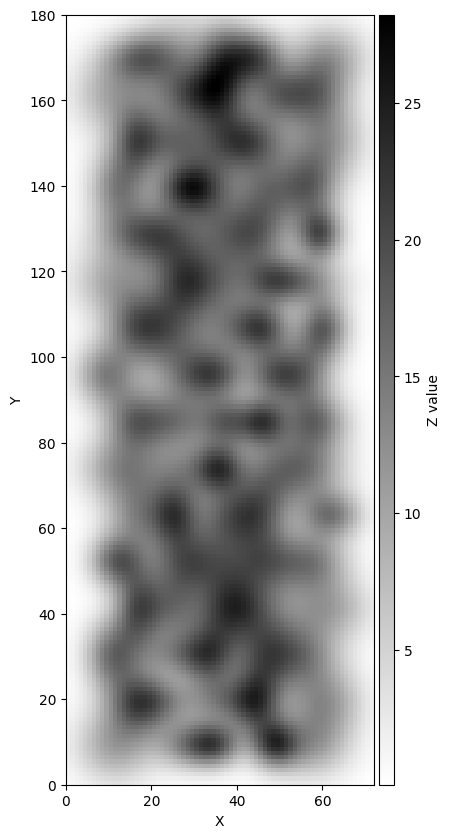

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_grayscale(x, y, mat["F_data"][:, :, 0], ax=ax)

## Save all gaussian

In [ ]:
def save_all_gaussians(mat):
    """
    Save all gaussians while maintaning the pixel dimensions
    Extracted from: https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
    """
    for save_id in range(0, mat["F_data"].shape[0]):
        plt.imsave(
            fname=f"docs/Data/Images_T80kenji/gaussian_{save_id}.png",
            arr=mat["F_data"][:, :, save_id],
            cmap="gray_r",
            format="png",
        )

In [ ]:
# Saving pngs - Save images
# save_all_gaussians(mat)

## Box of the gaussians - using dispersion_x and dispersion_y (from true parameters)

In [ ]:
# Load data
n_image = 313

# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(
    mat["Fit_flux"], n_image
)

In [ ]:
# Structure covariances
covariances = [
    np.diag(cov)
    for cov in zip(
        (dispersion_x / np.sqrt(2) / 1000) ** 2, (dispersion_y / np.sqrt(2) / 1000) ** 2
    )
]

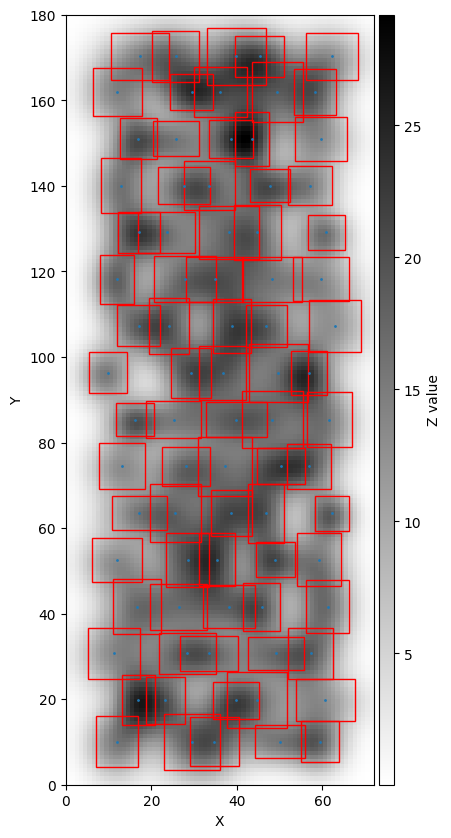

In [ ]:
# Display the image
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_boxes_gmm(
    means=list(zip(xs / 1000, ys / 1000)), covariances=covariances, ax=ax, beta=3
)
ax.scatter(xs, ys, s=1)
plot_grayscale(x, y, image[-1], colorbar=True, ax=ax)

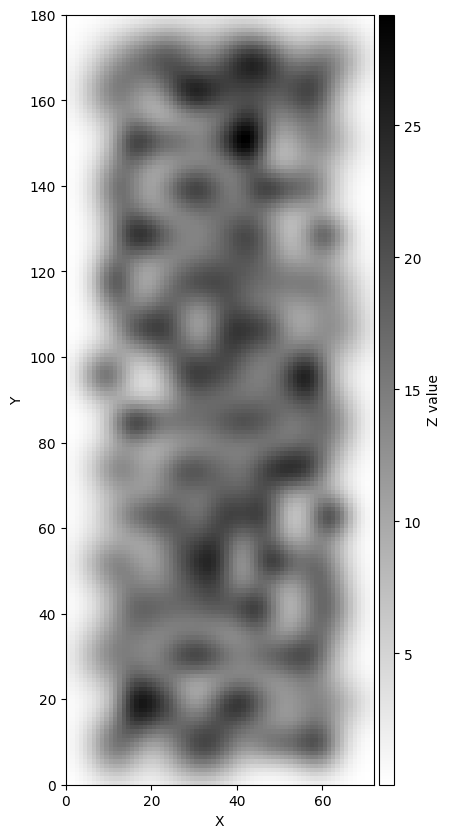

In [ ]:
# Display the image
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_grayscale(x, y, image[-1], colorbar=True, ax=ax)

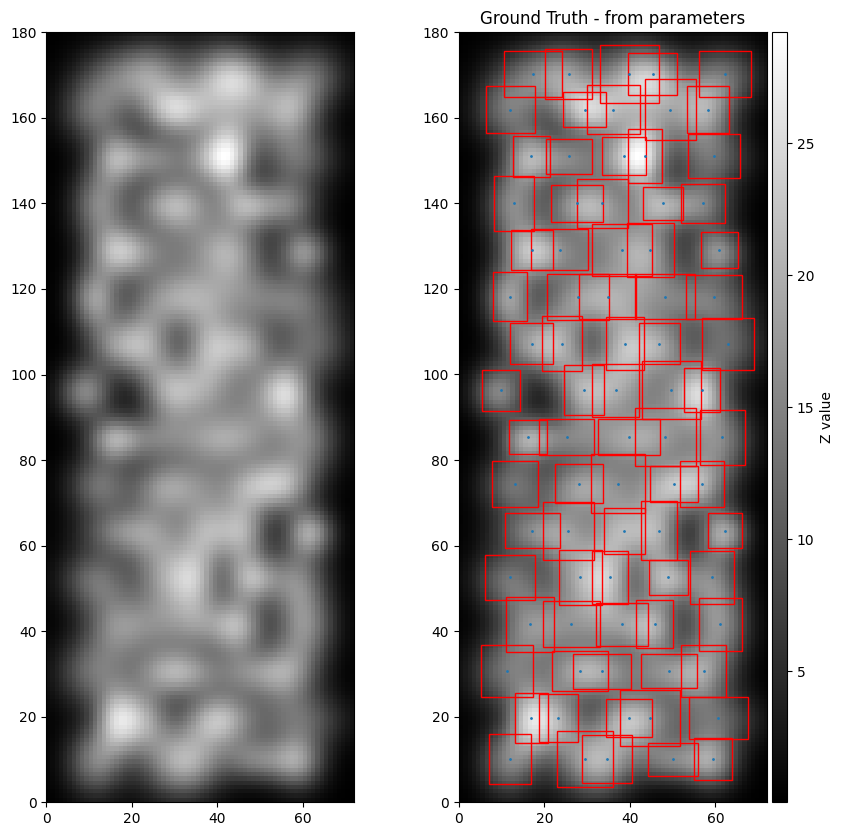

In [ ]:
# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Display the image
plot_boxes_gmm(
    means=list(zip(xs / 1000, ys / 1000)), covariances=covariances, ax=axs[1], beta=3
)
axs[1].set_title("Ground Truth - from parameters")
axs[1].scatter(xs, ys, s=1)

# Image
plot_grayscale(x, y, image[-1], colorbar=False, ax=axs[0])
plot_grayscale(x, y, image[-1], colorbar=True, ax=axs[1])

for ax in axs:
    ax.xaxis.label.set_text("")
    ax.yaxis.label.set_text("")

# [ESTIMATION PART II]
- Images: 400
- predict_T80kenji

## [ESTIMATION] Pipeline ppl_SCIKIT_GMM
- Processing using Scikit-image library
- Mean and covariances from GMM

In [ ]:
# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(
    mat["Fit_flux"], n_image
)

### Centers estimation

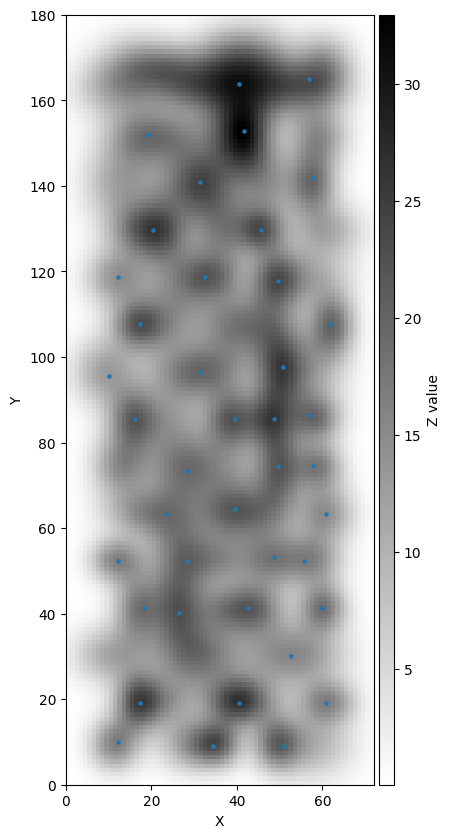

In [ ]:
# Find local maxima coordinates
coordinates = peak_local_max(image[2], min_distance=1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots(figsize=(15, 10))
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s=5)

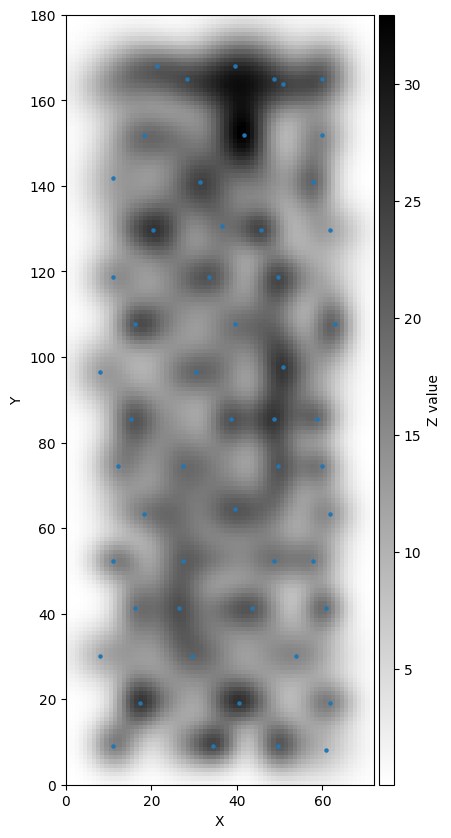

In [ ]:
# Find local maxima coordinates
z_laplace = laplace(image[2])
z_laplace[np.nonzero(z_laplace >= 0)] = 0
coordinates = peak_local_max(-1 * z_laplace, min_distance=1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots(figsize=(15, 10))
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s=5)

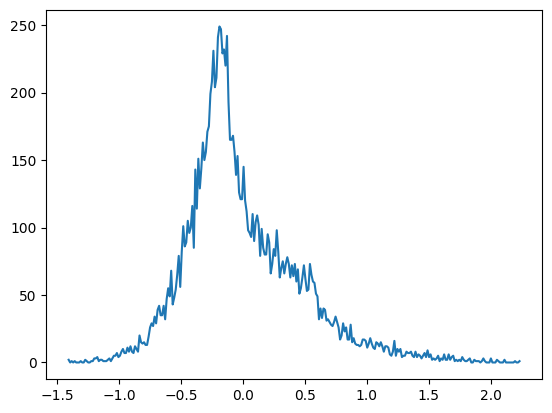

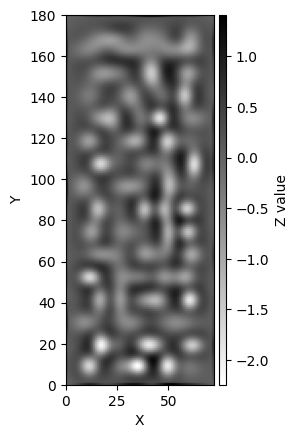

In [ ]:
# Thresholding laplacian
# histogram of values
histogram, bin_edges = np.histogram(-1 * laplace(image[2]), bins=300)

fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)

fig, ax = plt.subplots()
plot_grayscale(x, y, laplace(image[2]), ax)

estimate_parameters_gmm executed in 0.24471569061279297 seconds
ppl_fit_gaussians executed in 0.47582077980041504 seconds


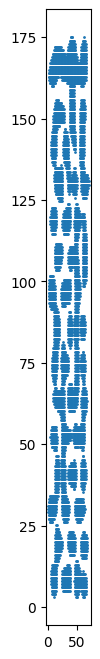

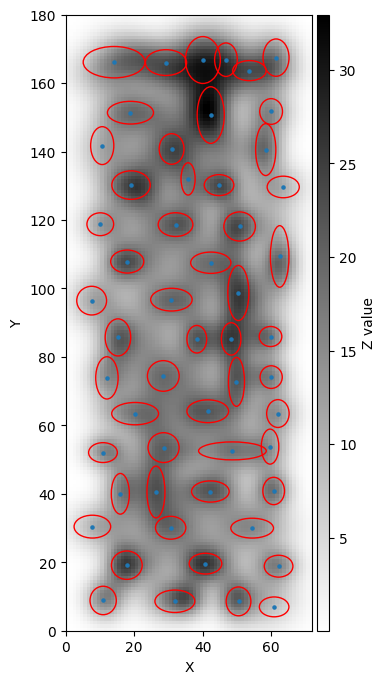

In [ ]:
# Estimate Gaussian - Final prediction
(means, covariances, angles, amplitudes) = ppl_fit_gaussians(
    image,
    means_init="laplace",
    peak_method="laplace",
    em_iterations=1000,
    covariance_gaussians_type="diag",
    n_gaussians=None,
    image_ranges=[
        (0, NOTEBOOK_CONFIG["IMG_WIDTH"]),
        (0, NOTEBOOK_CONFIG["IMG_LENGTH"]),
    ],
    image_size=[NOTEBOOK_CONFIG["IMG_XDIM"], NOTEBOOK_CONFIG["IMG_YDIM"]],
    fig_size=(10, 8),
    plot=True,
    plot_points=True,
)

Number of indentifiable Gaussians (center in the image): 80


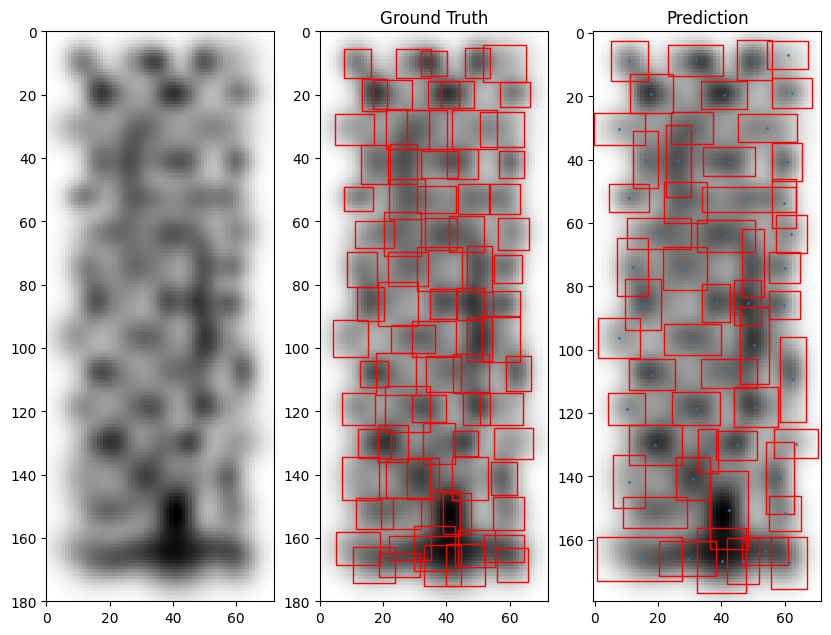

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(10, 10))

# Display the image
axs[2].imshow(im)
plot_boxes_gmm(means=means / 1000, covariances=covariances / 10e5, ax=axs[2], beta=3)
axs[2].set_title("Prediction")
axs[2].scatter(means[:, 0], means[:, 1], s=1)

# Labelling
x, y, z = gaussians_labelled(
    image_path,
    label_path,
    axs[1],
    task=NOTEBOOK_CONFIG["task"],
    colorbar=False,
    grid_width=NOTEBOOK_CONFIG["IMG_WIDTH"],
    grid_length=NOTEBOOK_CONFIG["IMG_LENGTH"],
    img_width=NOTEBOOK_CONFIG["IMG_XDIM"],
    img_length=NOTEBOOK_CONFIG["IMG_YDIM"],
)
axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar=False, ax=axs[0])

axs[0].invert_yaxis()
axs[1].invert_yaxis()

for ax in axs:
    ax.xaxis.label.set_text("")
    ax.yaxis.label.set_text("")

### Error evaluation
- Dispersion_x in the mat file is equal to sqrt(2) * sigma_x, same for y direction

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(len(eval_images))
print(eval_images)

40
[208, 304, 262, 288, 77, 230, 45, 115, 172, 188, 93, 323, 371, 8, 285, 200, 383, 365, 297, 31, 28, 193, 322, 144, 286, 191, 155, 291, 109, 194, 97, 209, 310, 301, 70, 324, 4, 357, 57, 242]


In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - gmm": [],
    "Number identifiable - gmm": [],
    "Percentage - gmm": [],
    "RMSE_cx - gmm": [],
    "RMSE_cy - gmm": [],
    "RMSE_c - gmm": [],
    "RMSE_sigmax - gmm": [],
    "RMSE_sigmay - gmm": [],
    "RMSE_sigma - gmm": [],
    "RMSE_amplitude - gmm": [],
    "MaxE_sigmax - gmm": [],
    "MaxE_sigmay - gmm": [],
    "MaxE_sigma - gmm": [],
    "RMSE_amplitude - gmm": [],
    "RMSEPixel - gmm": [],
}

for n_image in eval_images:
    print(n_image)
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        peak_method="laplace",
        estimation_method="gmm",
        covariance_gaussians_types="diag",
        return_percentage=True,
        image_ranges=NOTEBOOK_CONFIG["image_ranges"],
        image_size=NOTEBOOK_CONFIG["image_size"],
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]

208
estimate_parameters_gmm executed in 0.28348779678344727 seconds
ppl_fit_gaussians executed in 0.29427456855773926 seconds
covariances [[[     3.7617           0]
  [          0      3.3807]]]
covariances true [[[     3.8035           0]
  [          0      3.8212]]]
304
estimate_parameters_gmm executed in 0.26227426528930664 seconds
ppl_fit_gaussians executed in 0.27162694931030273 seconds
covariances [[[     4.6075           0]
  [          0      3.3945]]]
covariances true [[[     3.9016           0]
  [          0      4.6955]]]
262
estimate_parameters_gmm executed in 0.2835540771484375 seconds
ppl_fit_gaussians executed in 0.29172539710998535 seconds
covariances [[[     4.0713           0]
  [          0      19.251]]]
covariances true [[[     6.3612           0]
  [          0      4.5062]]]
288
estimate_parameters_gmm executed in 0.2514472007751465 seconds
ppl_fit_gaussians executed in 0.5240890979766846 seconds
covariances [[[     3.9305           0]
  [          0      3.49

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,203.22,112.45,383.00
Number identified - gmm,54.22,2.28,59.00
Number identifiable - gmm,80.00,0.00,80.00
Percentage - gmm,67.78,2.85,73.75
RMSE_cx - gmm,6.35,0.71,8.05
RMSE_cy - gmm,2.30,0.29,3.12
RMSE_c - gmm,6.76,0.68,8.29
RMSE_sigmax - gmm,20.92,1.89,24.31
RMSE_sigmay - gmm,25.52,3.10,35.94
RMSE_sigma - gmm,33.07,2.99,42.60


In [ ]:
pd.DataFrame.from_dict(results).round(2)

,Image,Number identified - gmm,Number identifiable - gmm,Percentage - gmm,RMSE_cx - gmm,RMSE_cy - gmm,RMSE_c - gmm,RMSE_sigmax - gmm,RMSE_sigmay - gmm,RMSE_sigma - gmm,RMSE_amplitude - gmm,MaxE_sigmax - gmm,MaxE_sigmay - gmm,MaxE_sigma - gmm,RMSEPixel - gmm
0,208,54,80,67.50,5.05,2.45,5.61,22.29,21.99,31.31,49.51,72.87,83.94,111.16,4.74
1,304,58,80,72.50,5.56,2.76,6.20,23.90,21.39,32.07,46.90,81.26,81.08,114.79,4.47
2,262,52,80,65.00,6.17,3.12,6.91,21.63,29.56,36.63,47.09,137.49,327.20,354.91,4.62
3,288,55,80,68.75,6.53,2.33,6.94,20.22,21.25,29.33,50.13,58.25,54.60,79.84,4.56
4,77,53,80,66.25,6.81,2.71,7.33,18.71,22.78,29.48,42.68,56.06,56.13,79.33,4.66
5,230,52,80,65.00,6.90,2.57,7.36,22.04,30.27,37.45,42.43,51.36,125.19,135.31,4.51
6,45,52,80,65.00,5.38,2.25,5.84,17.13,27.41,32.32,46.58,71.49,144.77,161.46,4.57
7,115,56,80,70.00,5.64,2.22,6.07,22.57,25.92,34.37,44.54,209.99,61.53,218.82,4.60
8,172,55,80,68.75,7.26,2.50,7.67,22.63,26.33,34.72,44.93,120.79,86.89,148.79,4.51
9,188,50,80,62.50,6.96,2.09,7.27,23.70,29.50,37.84,45.10,154.73,99.10,183.74,4.55


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {f"docs/Data/Images_T80kenji/gaussian_{n_image}.png"}\n
                 id_estimation_method = {"GMM - random state 13 - 400 images"}\n
                 id_images evaluated: {eval_images}""",
    name="T80kenjiGMM",
)

#### Total error

In [ ]:
# Computing error
gaussians = list(zip(means, covariances, amplitudes))

# Generate image from Gaussians and compute MSE
generated_image = sum_gaussians(x, y, gaussians)
mse = compute_mse(image[2], generated_image)